#### *CSC 180  Intelligent Systems (Spring 2021)*

#### *Dr. Haiquan Chen, Dept of Computer Scicence*

#### *California State University, Sacramento*
<hr>

## Project 1: Yelp Business Rating Prediction using Tensorflow
### **Team Members:** Quinn Roemer, Logan Hollmer

#### **Description:**
In this project we were tasked to create a neural network that predicted the star rating of a business based on the text of all the reviews for that business. The dataset used for this problem is provided by Yelp for academic use. This problem was considered a regression problem.

#### **Step 1:** Extract data from Yelp JSON files
The data provided by Yelp is downloaded as JSON files. To load the files into our TF-IDF vectorizer we needed to convert the JSON files into a Pandas dataframe. The code used for this task was provided by the professor.
<br>
<br>
**Note:** For this project we were only concerned with the ``yelp_academic_dataset_business.json`` and the ``yelp_academic_dataset_review.json`` files.


In [ ]:
#Convert yelp_academic_dataset_business.json and save to disk in ./data/review_count.tsv

import json
import csv
import os

#Create 'data' directory if missing
if not os.path.exists('./data'):
    os.mkdir('data')

#Open file
outfile = open("./data/review_count.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','review_count', 'business_stars'])

#Loop through the file
with open('yelp_academic_dataset_business.json', encoding="utf-8") as f:
    i=0
    for line in f:

        #Every 1000 lines print the current line count
        if (i%1000==0):            
            print("loading line: ", i)

        row = json.loads(line)        
        #Some special char must be encoded in 'utf-8'         
        sfile.writerow([row['business_id'], row['review_count'], row['stars']])
        i+=1


outfile.close()

In [ ]:
#Convert yelp_academic_dataset_review.json and save to disk in ./data/review_stars.tsv

import json
import csv
import os

#Create 'data' directory if missing
if not os.path.exists('./data'):
    os.mkdir('data')

#Open file
outfile = open("./data/review_stars.tsv", 'w')
sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
sfile.writerow(['business_id','stars', 'text'])

#Loop through the file
with open('yelp_academic_dataset_review.json', encoding="utf-8") as f:
    i=0
    for line in f:

        #Every 1000 lines print the current line count
        if (i%1000==0):            
            print("loading line: ", i)

        row = json.loads(line)        
        #Some special char must be encoded in 'utf-8'         
        sfile.writerow([row['business_id'], row['stars'], (row['text']).encode('utf-8')])
        i+=1


outfile.close()

#### **Step 2**: Group all reviews for a business on the same row
After saving the dataframes for later use we merged all the reviews onto the same row. As before, this code was provided by the professor.

In [ ]:
#Transform review_stars.tsv and save to disk as ./data/grouped_business_reviews.tsv

import pandas as pd

#Groups all reviews by business id
df = pd.read_csv('./data/review_stars.tsv', delimiter ="\t", encoding="utf-8")
df = df.groupby('business_id')['text'].sum()
df = pd.DataFrame({'business_id':df.index,'all_reviews':df.values})

#Save to disk for later use
df.to_csv('./data/grouped_business_reviews.tsv', index=False, sep='\t')

#Show the result
print(df)

#### **Step 3:** Drop businesses with less than 20 reviews
Another requirement of the project was to remove businesses with less than 20 reviews from the dataframe. This was done using the following code. In addition, this code drops a few other columns that were unnecessary such as ``business_id`` and ``review_count`` (after dropping review_count < 20).

In [ ]:
#Drops businesses with less than 20 reviews and a few other unnecessary columsn. The result is saved to disk
#as ./data/grouped_business_reviews_20.tsv

import pandas as pd

#Load both .tsv files into dataframes
reviewStars = pd.read_csv('./data/grouped_business_reviews.tsv', delimiter ="\t", encoding="utf-8")
reviewCount = pd.read_csv('./data/review_count.tsv', delimiter ="\t", encoding="utf-8")

#Merge dataframes on business_id
result = pd.merge(reviewCount, reviewStars, on=['business_id'])

#Drop if review_count is less than 20
result.drop(result[result['review_count'] < 20].index, inplace=True)

#Drop unnecessary fields, business_id, review_count
result.drop('business_id', axis=1, inplace=True)
result.drop('review_count', axis=1, inplace=True)

#Save the file to disk for later use
result.to_csv('./data/grouped_business_reviews_20.tsv', index=False, sep='\t')

#Show the result
print(result)

#### **Step 4:** Vectorize data using TF-IDF
After performing the above steps we are ready to vectorize the data using TF-IDF. Before passing the dataframe to the TF-IDF vectorizer we performed an X, Y split.
<br>
<br>
**Note:** The below settings used in the TF-IDF vecotorizer are what we used to create our best model. However, we also tried various other settings like ``max_features=1000`` and/or ``max_df=1970``.

In [ ]:
#Split X, Y and vectorize X using TF-IDF. Save to disk as ./data/x_tfidf.npy and ./data/y.npy

import pandas as pd
import numpy as np
import sklearn.feature_extraction.text as sk_text

#Read data into dataframe
df = pd.read_csv('./data/grouped_business_reviews_20.tsv', delimiter ="\t", encoding="utf-8")
print("Successfully loaded dataframe...")
print(df)

#Split data X and Y
x = df['all_reviews']
y = df['business_stars']
print("Sucessfully split X and Y...")
print(x)
print(y)

#Perform TF-IDF analyse on data
vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features=2000, min_df=30, lowercase=True)
x = vectorizer.fit_transform(x)
print("X vectorized using TF-IDF...")
print(x)
print(x.shape)
print(len(vectorizer.get_feature_names()))

#Save X and Y to disk as pickled NUMPY arrays
np.save('./data/x_tfidf.npy', x.toarray())
np.save('./data/y.npy', y.to_numpy())
print("Successfuly saved data to disk.")

#### **Step 5:** Training the model
One of the requirements for this project is performing a train/test split and using a monitor to prevent overfitting. These both can be found in the code below.
<br>
<br>
After performing the necessary steps to prepare our data, we are ready to begin training our models. To do this we tried various approaches varying the activation functions ``['relu', 'sigmoid', 'tanh']``, number of layers (1-3) and neuroun count (10-100) for each layer. In addition, the ``SGD`` and ``Adam`` optimizers were both tried for each model created. These changes were automated using the below script. Each model was run 3 times with each optimizer.
<br>
<br>
**Note:** For each model created, the best model for each optimizer was saved over the 3 runs. Along with the model settings (including RMSE score of the model) and the MathPlotLib lift chart.

In [ ]:
#Script used to train the model. Tries various model settings saving each model created 
#under the ./dnn/models directory

from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import random
import time

#Regression chart.
#Provided by Dr. Haiquan Chen
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    a = plt.plot(t['pred'].tolist(), label='prediction')
    b = plt.plot(t['y'].tolist(), label='expected')
    plt.ylabel('output')
    plt.legend()
    plt.savefig("./dnn/models/current/best.png")
    plt.close()


#Create 'dnn' directory if missing
if not os.path.exists('./dnn'):
    os.mkdir('dnn')

#Sleep 1 second to avoid file directory errors
time.sleep(1)

#Create 'dnn/models' directory if missing
if not os.path.exists('./dnn/models'):
    os.mkdir('./dnn/models')

#Load saved numpy arrays
x = np.load('./data/x_tfidf.npy', allow_pickle=True)
y = np.load('./data/y.npy', allow_pickle=True)

#Train/test split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42)

#Choose a random value hidden layers between 1-5
while True:
    activation = ['relu', 'sigmoid', 'tanh']
    neurounCounts = []
    activaters = []
    layerCount = random.randint(1, 3)
    outStr = ""

    #Fill neuronCounts for all layers
    for temp in range(0, layerCount):
        neurounCounts.append(random.randint(10, 100))
        activaters.append(random.choice(activation))
        outStr += "Hidden Layer " + str(temp + 1) + ": Neuron Count = " + str(
            neurounCounts[temp]) + " Activater = " + activaters[0] + "\n"

    #Create current directory
    if not os.path.exists('./dnn/models/current'):
        os.mkdir('./dnn/models/current')

    #Callbacks
    monitor = EarlyStopping(
        monitor='val_loss', min_delta=1e-3, patience=3, verbose=2, mode='auto')
    checkpointer = ModelCheckpoint(
        filepath="./dnn/models/current/best_weights.hdf5", verbose=0, save_best_only=True)

    #?Run with adam as the optimizer 3 times, saving the best model
    for rep in range(0, 3):
        modelAdam = Sequential()

        #Create the model with the determined settings
        for temp in range(0, layerCount):
            if temp == 0:
                modelAdam.add(
                    Dense(neurounCounts[temp], input_dim=x.shape[1], activation=activaters[temp]))
                continue
            modelAdam.add(
                Dense(neurounCounts[temp], activation=activaters[temp]))

        #Create the output layer
        modelAdam.add(Dense(1))

        modelAdam.compile(loss='mean_squared_error', optimizer='adam')
        print("\nRunning Adam Model: ", rep + 1)
        modelAdam.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[
                      monitor, checkpointer], verbose=2, epochs=100)
        pred = modelAdam.predict(x_test)
        score = np.sqrt(metrics.mean_squared_error(pred, y_test))
        print("RMSE: ", score)

    #Save best model info
    #Sleep to prevent file renaming errors
    time.sleep(1)
    modelAdam.load_weights('./dnn/models/current/best_weights.hdf5')
    pred = modelAdam.predict(x_test)
    score = np.sqrt(metrics.mean_squared_error(pred, y_test))
    print("Final model score: ", score)
    text_file = open("./dnn/models/current/settings.txt", "w")
    text_file.write(outStr + "RMSE Score: " + str(score) + "\nOptimizer: Adam")
    text_file.close()
    chart_regression(pred.flatten(), y_test, sort=True)
    try:
        os.rename("./dnn/models/current", "./dnn/models/" + str(score))
    except OSError:
        os.remove("./dnn/models/current/best_weights.hdf5")
        os.remove("./dnn/models/current/best.png")
        os.remove("./dnn/models/current/settings.txt")
        os.rmdir("./dnn/models/current")

    #?Run with sgd as the optmizer 3 times, saving the best model
    #Sleep 1 sec to avoid file renaming erros
    time.sleep(1)

    #Create current directory
    if not os.path.exists('./dnn/models/current'):
        os.mkdir('./dnn/models/current')

    #Create new callbacks
    monitor = EarlyStopping(
        monitor='val_loss', min_delta=1e-3, patience=3, verbose=2, mode='auto')
    checkpointer = ModelCheckpoint(
        filepath="./dnn/models/current/best_weights.hdf5", verbose=0, save_best_only=True)

    for rep in range(0, 3):
        modelSGD = Sequential()

        #Create the model with the determined settings
        for temp in range(0, layerCount):
            if temp == 0:
                modelSGD.add(
                    Dense(neurounCounts[temp], input_dim=x.shape[1], activation=activaters[temp]))
                continue
            modelSGD.add(
                Dense(neurounCounts[temp], activation=activaters[temp]))

        #Create the output layer
        modelSGD.add(Dense(1))

        modelSGD.compile(loss='mean_squared_error', optimizer='sgd')
        print("\nRunning SGD Model: ", rep + 1)
        modelSGD.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[
                     monitor, checkpointer], verbose=2, epochs=100)
        pred = modelSGD.predict(x_test)
        score = np.sqrt(metrics.mean_squared_error(pred, y_test))
        print("RMSE: ", score)

    #Save best model info
    #Sleep to prevent file renaming errors
    time.sleep(1)
    modelSGD.load_weights('./dnn/models/current/best_weights.hdf5')
    pred = modelSGD.predict(x_test)
    score = np.sqrt(metrics.mean_squared_error(pred, y_test))
    print("Final model score: ", score)
    text_file = open("./dnn/models/current/settings.txt", "w")
    text_file.write(outStr + "RMSE Score: " + str(score) + "\nOptimizer: SGD")
    text_file.close()
    chart_regression(pred.flatten(), y_test, sort=True)
    try:
        os.rename("./dnn/models/current", "./dnn/models/" + str(score))
    except OSError:
        os.remove("./dnn/models/current/best_weights.hdf5")
        os.remove("./dnn/models/current/best.png")
        os.remove("./dnn/models/current/settings.txt")
        os.rmdir("./dnn/models/current")

    #Sleep to prevent file renaming errors
    time.sleep(1)

#### **Step 6:** The best model created
After running the script overnight, we were able to create a model with an RMSE score of 0.24992. This model was created with the below settings:
<br>
<br>
***Not including the input and output layers***<br>
Hidden Layer #1: Neuron Count = 96, Activater = tanh<br>
Hidden Layer #2: Neuron Count = 13, Activater = tanh<br>
Hiden Layer #3: Neuron Count = 15, Activater = tanh<br>
Optimizer: Adam
<br>
<br>
In the models we created with the script, we found that the best were often created when using the same activation functions across all layers (often using tanh), having a low number of hidden layers with a receding number of neuron counts while using the Adam optimizer.
<br>
<br>
Since it is difficult to create the exact model using the above code, you can download our ``best_model.hdf5`` file from Google Drive by clicking <a href="https://drive.google.com/file/d/1Bn5qkRNmeIyc63J9sGtCGLzHQ3Gllzmv/view?usp=sharing">here</a>. The below code uses it to print out its RMSE score and lift chart.





RMSE Score:  0.24992011554806517




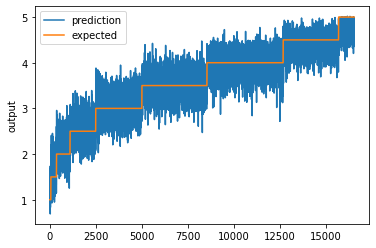

In [36]:
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

FILENAME = './best_model.hdf5'

#Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['pred'].tolist(),label='prediction')
    b = plt.plot(t['y'].tolist(),label='expected')
    plt.ylabel('output')
    plt.legend()
    plt.show()

#Load saved numpy arrays
x = np.load('./data/x_tfidf.npy', allow_pickle=True)
y = np.load('./data/y.npy', allow_pickle=True)

#Train/test split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42)

try:
    model = tf.keras.models.load_model(FILENAME)
except OSError:
    print('\nCould not open best_model.hdf5. Please save it in the directory this file exists.')
    exit(1)

#Show RMSE score and lift chart
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("\nRMSE Score: ", score)
print("\n")
chart_regression(pred.flatten(), y_test, sort=True)

#### **Step 7:** Choose 3-5 arbitrary businesses and test with your model
The last step of this project is to use our best model and show its predictions on 3-5 arbitrary inputs. The below code does this on the model loaded during the last step.
<br>
<br>
**Note:** If you haven't downloaded the model file and ran the code to produce the model, example output can be found below the code.

In [ ]:
#Saves new numpy arrays that contain business_name, categories, etc. Since I did not save that info in my original arrays

import csv
import json
import sklearn.feature_extraction.text as sk_text
import pandas as pd
import numpy as np
import os

def save_review_count():
    #Create 'data' directory if missing
    if not os.path.exists('./data'):
        os.mkdir('data')

    #Open file
    outfile = open("./data/business_info.tsv", 'w')
    sfile = csv.writer(outfile, delimiter ="\t", quoting=csv.QUOTE_MINIMAL)
    sfile.writerow(['business_id','review_count', 'business_stars', 'name', 'categories'])

    #Loop through the file
    with open('yelp_academic_dataset_business.json', encoding="utf-8") as f:
        i=0
        for line in f:
            row = json.loads(line)        
            #Some special char must be encoded in 'utf-8'         
            sfile.writerow([row['business_id'], row['review_count'], row['stars'], row['name'], row['categories']])
            i+=1
    outfile.close()

#Load review_stars
review_stars = pd.read_csv('./data/grouped_business_reviews.tsv', delimiter ="\t", encoding="utf-8")

#Load review_count
save_review_count()
review_count = pd.read_csv('./data/business_info.tsv', delimiter ="\t", encoding="utf-8")
print(review_count)

#Merge and drop business with less than 20 reviews
result = pd.merge(review_count, review_stars, on=['business_id'])
result.drop(result[result['review_count'] < 20].index, inplace=True)
print(result)

y = result[['name', 'business_stars', 'categories']]
x = result['all_reviews']

#Perform TF-IDF analyse on data
vectorizer = sk_text.TfidfVectorizer(stop_words='english', max_features=2000, min_df=30, lowercase=True)
x = vectorizer.fit_transform(x)
print("X vectorized using TF-IDF...")
print(x)
print(x.shape)
print(len(vectorizer.get_feature_names()))

np.save('./data/x_arbitrary.npy', x.toarray())
np.save('./data/y_arbitrary.npy', y.to_numpy())

In [35]:
import numpy as np

def print_pretty(y, pred):
    for index in range(0, 5):
        print(str(y[index][0]) + "\n\tPredicted Rating = " + str(pred.item(index)) + "\n\tActual Rating = " + str(y[index][1]) + "\n\tCategories: " + str(y[index][2]) + "\n\n")

#Load saved numpy arrays
x = np.load('./data/x_arbitrary.npy', allow_pickle=True)
y = np.load('./data/y_arbitrary.npy', allow_pickle=True)

#Grab the same random sample from each
rSam = np.random.choice(np.arange(len(x)), 5, replace=False)
y = y[rSam]
x = x[rSam]

#Predict
pred = model.predict(x)

#Print result
print_pretty(y, pred)




Le Petit Cafe
	Predicted Rating = 4.662838935852051
	Actual Rating = 4.5
	Categories: Cafes, Food, Chocolatiers & Shops, Wedding Planning, Event Planning & Services, Specialty Food, Bakeries, Breakfast & Brunch, Restaurants, Local Flavor, Cupcakes, Coffee & Tea


Nando's Mexican Cafe
	Predicted Rating = 3.43556547164917
	Actual Rating = 3.5
	Categories: Mexican, Restaurants


The Home Depot
	Predicted Rating = 2.64905047416687
	Actual Rating = 2.5
	Categories: Building Supplies, Appliances, Home Services, Hardware Stores, Nurseries & Gardening, Home & Garden, Shopping


Deville Dinerbar
	Predicted Rating = 3.861707925796509
	Actual Rating = 4.0
	Categories: American (Traditional), American (New), Diners, Canadian (New), Restaurants


Bikram Yoga Green Valley
	Predicted Rating = 3.849273443222046
	Actual Rating = 3.5
	Categories: Active Life, Fitness & Instruction, Yoga


